In [1]:
import os
import numpy as np
import tensorflow
import mne
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal as ss
from scipy.stats import kurtosis, zscore
from sklearn import preprocessing
import keras
import PyQt5
from sklearn.model_selection import train_test_split
import pandas as pd
# %matplotlib notebook
mne.set_log_level(verbose='CRITICAL')

Using TensorFlow backend.


In [2]:
male_participants = ['m'+str(i) for i in range(1,19)]
female_participants = ['k'+str(i) for i in range(1,19)]
all_participants = set(male_participants + female_participants) - {'k7','k8','k10','k11','k12','k13','m14','m16'}
good_participants = sorted(list(all_participants))
bad_channels = [['T4','T3','T6'],['Fz','Fp1','Fp2','F4'],['Fp1','Fp2','Fz'],
                ['P3','O2'],['O1','O2'],['F3','Fz','F4','F8','Fp1','Fp2'],['T4','P4'],[],[],[],[],[],
                ['O1','O2'],[],['O1','O2','Fz','F4','Fp1','Fp2'],['F3','Fz','F4','Fp1','Fp2'],['F3'],
                ['T4','Fz','Fp1','Fp2'],['O1','O2','T6','F4','Fp2'],[],[],['Pz'],['F3','Fz','F4','Fp1','Fp2'],
                ['F3','Fz','F4','Fp1','Fp2'],[],['O1','O2'],['T4','O1','T3'],['F3','Fz','F4','Fp1','Fp2']]
channels_dict = {}
for i in range(len(good_participants)):
    channels_dict[good_participants[i]] = bad_channels[i]


In [34]:
def get_bad_epochs(signal,percentiles = [25,75]): #shape = ( epochs, channels, samples)
    channels = signal.shape[1]
    Qstd = np.std(signal,axis = -1)
    Qkurt = kurtosis(signal,axis = -1)
    bads = np.empty(0)
    for i in range(channels):
        Q1,Q3 = np.percentile(Qstd[:,i],percentiles)
        IQR = Q3-Q1
        range_std = (Q1-1.5*IQR,Q3+1.5*IQR)
        Q1,Q3 = np.percentile(Qkurt[:,i],percentiles)
        IQR = Q3-Q1
        range_kurt = (Q1-1.5*IQR,Q3+1.5*IQR)
        right_std = np.where(Qstd[:,i] > range_std[1])[0]
        left_std = np.where(Qstd[:,i] < range_std[0])[0]
        right_kurt = np.where(Qkurt[:,i] > range_kurt[1])[0]
        left_kurt = np.where(Qkurt[:,i] < range_kurt[0])[0]
        bads = np.unique(np.concatenate((bads,left_kurt,right_kurt,left_std,right_std)))
    return bads

def RMS(signal, window_size):
    signal2 = signal**2
    window = np.ones(window_size)/window_size
    return np.sqrt(np.convolve(signal2, window, 'same'))

def preprocess_raw(filename,bad_channels):
    f = mne.io.read_raw_eeglab(filename,preload=True)
    f.set_eeg_reference(ref_channels=['A1','A2'])
    f.drop_channels(['EOG','dioda','TSS','A1','A2'])
    f.filter(0.5,49) #sprawdzić fcje przenoszenia, spr jak sygnały się zachowują, czy filtruje w dwie strony
    ile = len(f.event['latency'])
    EVENTS = np.zeros((ile,3))
    EVENTS[:,0] = f.event['latency']
    EVENTS[:,1] = 0
    EVENTS[:,2] = 1
    f.info['bads'] = bad_channels
    f.interpolate_bads(reset_bads=False, mode='accurate', origin=[0,0,0])
    mistakes = np.array([True if i['word_type']!=i['decision'] else False for i in f.event['tag_type']])
    return f, mistakes , EVENTS.astype(int), pd.DataFrame(f.event['tag_type'])

def preprocess_epochs(filename,bad_channels):
    data, mistakes, events, meta = preprocess_raw(filename,bad_channels)
    chann = np.array(data.ch_names)
    epo = mne.Epochs(data, events, baseline = (-0.2,0), metadata = meta, tmin= -0.2, tmax=1, preload=True)
    epo.drop(mistakes)
    epo.drop(get_bad_epochs(epo.get_data()))
    epo.resample(256)
    Fs = int(epo.info['sfreq'])
    word_type = np.array([0 if i == 'p' else 1 for i in epo._metadata['word_type']]).astype(int)
    return epo, word_type, Fs, chann

def make_freq_bands(epo, method):
    epoki_mid = epo.copy().filter(14,30,method=method).get_data()
    epoki_high = epo.copy().filter(30,49,method=method).get_data()
    epoki_low = epo.copy().filter(1,14,method=method).get_data()
    return zscore(epoki_low), zscore(epoki_mid), zscore(epoki_high) #dokładnie doczytać 
#std po kanałach osobno, w pasmach osobno, w okresie referencyjnym, spr czy na brzegach się nie psuje,
#rysunki sygnałów przed i po każdym etapie

def RMS_epochs(epochs,window_length=32): #(epochs, channels, samples)
    return np.apply_along_axis(RMS,-1,epochs,window_length)
#przesunięcie po jednej próbce, 
#obniżyć FS do 128
def final_data(filename, bad_channels):
    epo, word_type, fs, ch = preprocess_epochs(filename,bad_channels)
    epo1, epo2, epo3 = make_freq_bands(epo, 'fir')
    empty = np.empty((epo1.shape[0], epo1.shape[1], epo1.shape[2], 3))
    empty[:,:,:,0] = RMS_epochs(epo1)
    empty[:,:,:,1] = RMS_epochs(epo2)
    empty[:,:,:,2] = RMS_epochs(epo3)
    return empty, word_type, fs, ch

In [35]:
test_participant = 'k2'
signal, y, Fs, channels = final_data('./data2/'+test_participant+'.set' , channels_dict[test_participant])

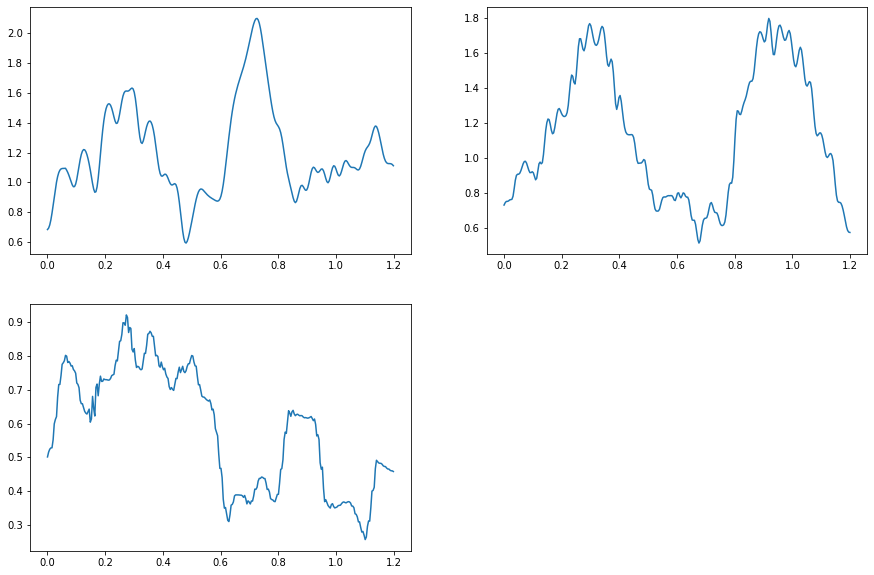

In [36]:
ch = 7
ep = 100
window_len = 32
time = np.arange(0,signal.shape[2]/Fs,1/Fs)
# sprawdź widma, w jakich częstościach się coś dzieje, jeśli w niskich to zrobić downsample w pasmach
#równolegle można pisać, po każdym etapaie - rysunki (sprawdzić dla spokoju ducha), niektóre może do pracy
# dokumentacja co się dzieje z sygnałem 
# rząd 200, przesunięcie o 100 próbek,
# odpowiedź impulsowa - gdzie stoi
plt.figure(figsize = (15,10))
plt.subplot(2,2,1)
plt.plot(time, signal[ep,ch,:,0])

plt.subplot(2,2,2)
plt.plot(time, signal[ep,ch,:,1])

plt.subplot(2,2,3)
plt.plot(time, signal[ep,ch,:,2])

plt.show()

In [37]:
X = np.empty((0,signal.shape[1],signal.shape[2],signal.shape[3]))
y = np.empty((0))
for participant, bad_ch in channels_dict.items():
    signal, w_type, Fs, channels = final_data('./data2/'+participant+'.set' , bad_ch)
    X = np.concatenate((X,signal))
    y = np.concatenate((y,w_type))

In [41]:
np.save('RMS_X.npy',X)
np.save('RMS_y.npy',y)